In [23]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy as cy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import s3fs
import intake

## Sum/average nr of AR by year?

Functions

In [3]:
def circle_for_polar_map(axes):
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    axes.set_boundary(circle, transform=axes.transAxes)
    
def count_2020_ARs(ds, lat_cut):
    if lat_cut<0:
        pole_ds = ds.sel(lat= slice(-90, lat_cut))
    else:
        pole_ds = ds.sel(lat= slice(lat_cut, 90))
    ar_counts = np.zeros(len(pole_ds.time))
    for i,ts in enumerate(pole_ds.time):
        ar_ts = pole_ds.sel(time = ts).ar_binary_tag.squeeze()
        ar_ts = xr.where(ar_ts>1,1,0)
        ll = xr.plot.contour(ar_ts, levels=[0.0,1.0])
        plt.close()
        ar_list = np.array([len(p) for p in ll.collections[0].get_paths()])
        ar_counts[i] = len(ar_list[ar_list>20])
    ds[f'ar_counts_{lat_cut}']= (['time'], ar_counts)
    return ds

def count_ARs(ds, lat_cut):
    '''
    Counts number of AR at each time step. Returns dataset with added coordinate ar_counts_[lat_cut].
    '''
    if lat_cut<0:
        pole_ds = ds.sel(lat= slice(-90, lat_cut))
    else:
        pole_ds = ds.sel(lat= slice(lat_cut, 90))

    ar_counts = np.zeros(len(pole_ds.time))
    for i,ts in enumerate(pole_ds.time):
        ll = xr.plot.contour(pole_ds.sel(time=ts).ivt, levels=[0.0,1.0])
        plt.close()
        if len(ll.collections)>1: #You can remove this and next line if you have run it a few times without getting the printout :))
            print('julia was wrong about something, tell her to fix it'+ts) 
        nr_ar = len(ll.collections[0].get_paths())
        ar_counts[i] = nr_ar
    ds[f'ar_counts_{lat_cut}']= (['time'], ar_counts)
    return ds

In [3]:
AR_2020_file = 'AR_detection_2020.nc4'
data_dir = '/home/jovyan/Tjaernoe2022-group5/data'
ar_2020 = xr.open_dataset(os.path.join(data_dir,AR_2020_file))

In [4]:
daily_2020 = ar_2020.groupby('time.dayofyear').sum()
daily_2020['dayofyear'] =  np.unique(ar_2020.time.dt.floor('D'))
daily_2020 = daily_2020.rename({'dayofyear':'time'})

In [5]:
AR_comp_file = '20002015_AR_detection.nc'
ar_comp = xr.open_dataset(AR_comp_file)

Count ARs:

In [6]:
counted_2020 = count_2020_ARs(daily_2020,60)
counted_2020 = count_2020_ARs(counted_2020,-60)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/plot/plot.py:1417: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


In [11]:
counted_comp = count_ARs(ar_comp, 60)
counted_comp = count_ARs(counted_comp, -60)

In [13]:
counted_comp.to_netcdf(AR_comp_file[:-3]+'_counted.nc')
counted_2020.to_netcdf(AR_2020_file[:-4]+'_counted.nc')

In [30]:
print(counted_comp.ar_counts_60.sum()/15)
print(counted_2020.ar_counts_60.sum())

<xarray.DataArray 'ar_counts_60' ()>
array(286.2)
<xarray.DataArray 'ar_counts_60' ()>
array(253.)


In [31]:
print(counted_comp['ar_counts_-60'].sum()/15)
print(counted_2020['ar_counts_-60'].sum())

<xarray.DataArray 'ar_counts_-60' ()>
array(260.13333333)
<xarray.DataArray 'ar_counts_-60' ()>
array(258.)


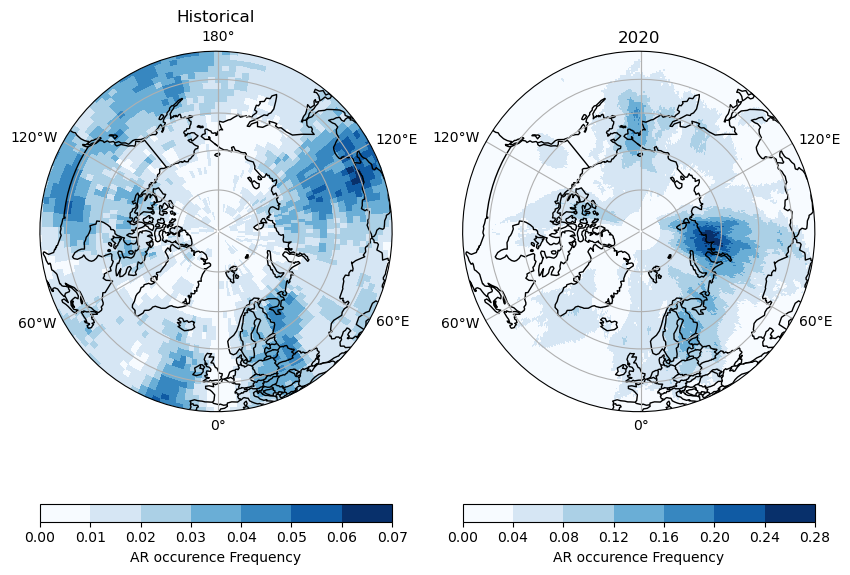

In [51]:
f,ax = plt.subplots(1,2,dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
counted_comp.sel(lat=slice(40,90), time=slice('2011-01-01','2011-12-31')).ivt.mean(dim='time').plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax[0],
    cbar_kwargs={
        'label':'AR occurence Frequency', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)
counted_2020.ar_binary_tag.mean(dim='time').plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax[1],
    cbar_kwargs={
        'label':'AR occurence Frequency', 
        'orientation':'horizontal',     
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)
for a in ax:
    a.coastlines()
    circle_for_polar_map(a)
    a.set_extent([0, 360, 40, 90], ccrs.PlateCarree())
    gl = a.gridlines(draw_labels=True)
    a.add_feature(cy.feature.BORDERS)
    
ax[0].set_title('Historical')
ax[1].set_title('2020')

gl.top_labels = False
gl.right_labels = False

plt.show()

In [2]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
#s3.ls('escience2022/Remy/')

['escience2022/Remy/.keep',
 'escience2022/Remy/.wget-20221102193645.sh.status',
 'escience2022/Remy/.wget-20221102193729.sh.status',
 'escience2022/Remy/.wget-20221102193735.sh.status',
 'escience2022/Remy/.wget-20221102193742.sh.status',
 'escience2022/Remy/Era5',
 'escience2022/Remy/dl_era5_hus.py',
 'escience2022/Remy/dl_era5_wind.py',
 'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20150101-20201231.nc',
 'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20210101-20301231.nc',
 'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20310101-20401231.nc',
 'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20410101-20501231.nc',
 'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20510101-20601231.nc',
 'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20610101-20701231.nc',
 'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20710101-20801231.nc',
 'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20810101-20901231.nc',
 'escience

In [3]:
s3path_hist1_aod = 's3://escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_20000101-20091231.nc'
s3path_hist2_aod = 's3://escience2022/Remy/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_20100101-20141231.nc'

hist1_aod = xr.open_dataset(s3.open(s3path_hist1_aod), drop_variables =['time_bnds','lat_bnds','lon_bnds'])
hist2_aod = xr.open_dataset(s3.open(s3path_hist2_aod), drop_variables =['time_bnds','lat_bnds','lon_bnds'])

In [4]:
start_year='2000'
end_year='2015'

In [5]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [6]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['clt','pr','tas'], member_id=['r1i1p1f1'])
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
dataset_list = list(dset_dict.keys())
dset = dset_dict[dataset_list[0]]
hist_vars = dset.sel(member_id='r1i1p1f1',time=slice(str(start_year)+"-01-01", str(end_year)+"-01-01"))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
ar_hist = xr.open_dataset('20002015_AR_detection_counted.nc')

In [8]:
aod_hist = xr.merge([hist1_aod, hist2_aod])

In [9]:
aod_hist

<xarray.Dataset>
Dimensions:     (time: 5475, lat: 96, lon: 144)
Coordinates:
  * time        (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    wavelength  float64 550.0
Data variables:
    od550aer    (time, lat, lon) float32 1.004 1.004 1.004 ... 1.015 1.015 1.015
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1600-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     430335.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               od550aer
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/3ce70ca9-d644-452d-8cec-b385c7a6a89d

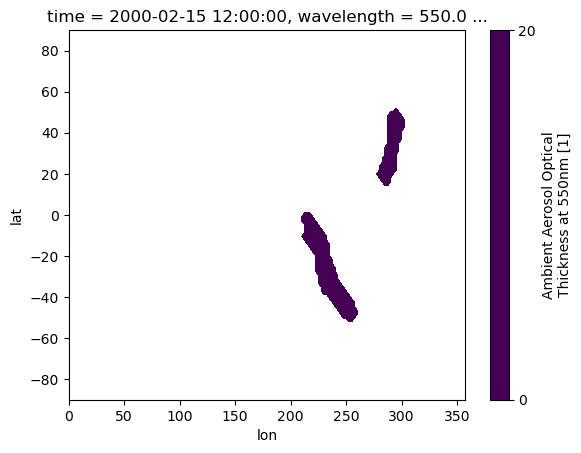

In [119]:
ll = xr.plot.contourf(aod_hist.where(ar_hist.ivt==True).sel(time='2000-02-15').od550aer.squeeze(), levels=[0,20])

In [128]:
for item in ll.collections[0].get_paths():
    v = item.vertices
    lat = v[:,1]
    lon = v[1,:]
    
def average_in_box(array, lon, lat):
    test.sel(lat=slice())

In [132]:
test.sel(lat=slice(np.min(lat), np.max(lat)), lon = slice(np.min(lon), np.max(lon))).mean()

<xarray.DataArray 'od550aer' ()>
array(1.1519277, dtype=float32)
Coordinates:
    wavelength  float64 550.0

In [124]:
ll.collections[0].get_paths()[0]

Path(array([[252.5       , -52.10526316],
       [255.        , -52.10526316],
       [257.5       , -50.21052632],
       [260.        , -48.31578947],
       [260.        , -46.42105263],
       [257.5       , -44.52631579],
       [257.5       , -42.63157895],
       [255.        , -40.73684211],
       [252.5       , -38.84210526],
       [250.        , -36.94736842],
       [247.5       , -35.05263158],
       [245.        , -33.15789474],
       [242.5       , -31.26315789],
       [242.5       , -29.36842105],
       [240.        , -27.47368421],
       [240.        , -25.57894737],
       [237.5       , -23.68421053],
       [237.5       , -21.78947368],
       [235.        , -19.89473684],
       [235.        , -18.        ],
       [235.        , -16.10526316],
       [235.        , -14.21052632],
       [232.5       , -12.31578947],
       [232.5       , -10.42105263],
       [230.        ,  -8.52631579],
       [227.5       ,  -6.63157895],
       [225.        ,  -4.7368421

In [131]:
test = aod_hist.where(ar_hist.ivt==True).sel(time='2000-02-02').od550aer

In [61]:
ll = plt.contourf(test,levels=[0,20])
plt.close()
for item in ll.collections:
    for i in item.get_paths():
        v = i.vertices
        crit = abs(np.max(v[:, 1])-np.min(v[:, 1]))
        if (crit>=20): # AR has to be at least 20 deg lat 
            xx=(v[:, 0]).astype(int)
            yy=(v[:, 1]).astype(int)
            for (x,y) in zip(xx,yy):
                out_loc[y,tt,x] = 1

<xarray.DataArray 'od550aer' (time: 1, lat: 96, lon: 144)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time        (time) object 2000-02-02 12:00:00
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    wavelength  float64 550.0
Attributes:
    standard_name:  atmosphere_optical_thickness_due_to_ambient_aerosol_parti...
    long_name:      Ambient Aerosol Optical Thickness at 550nm
    comment:        AOD from the ambient aerosols (i.e., includes aerosol wat...
    units:          1
    original_name:  DOD550/DAYFOC
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-17T18:33:44Z altered by CMOR: Treated scalar dime...

In [62]:
test.squeeze().values.shape

(96, 144)

In [63]:
np.nonzero(test.squeeze().values)

(array([52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55,
        56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59,
        59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60,
        60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 61,
        61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62,
        62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65,
        65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66,
        66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67,
        68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69,
        69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 71,
        71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72,
        72, 

In [ ]:
aod_ar_hist= aod_hist.where(ar_hist.ivt==True, drop=True).sel(lat = slice(60,90)) #selecting arctic only!

In [13]:
aod_ar_hist

<xarray.Dataset>
Dimensions:     (time: 4341, lat: 16, lon: 144)
Coordinates:
  * time        (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lat         (lat) float64 61.58 63.47 65.37 67.26 ... 84.32 86.21 88.11 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    wavelength  float64 550.0
Data variables:
    od550aer    (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1600-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     430335.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               od550aer
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/3ce70ca9-d644-452d-8cec-b385c7a6a89d

In [17]:
hist_poll_ar = hist_vars.where(aod_ar_hist.od550aer>aod_ar_hist.od550aer.quantile(0.75),drop=True)

In [18]:
hist_clean_ar = hist_vars.where(aod_ar_hist.od550aer<aod_ar_hist.od550aer.quantile(0.25),drop=True)

In [19]:
clean_clt = hist_clean_ar.clt.values.flatten()[~np.isnan(hist_clean_ar.clt.values.flatten())]
poll_clt = hist_poll_ar.clt.values.flatten()[~np.isnan(hist_poll_ar.clt.values.flatten())]

In [20]:
clean_pr = hist_clean_ar.pr.values.flatten()[~np.isnan(hist_clean_ar.pr.values.flatten())]
poll_pr = hist_poll_ar.pr.values.flatten()[~np.isnan(hist_poll_ar.pr.values.flatten())]

In [22]:
hist_poll_ar

<xarray.Dataset>
Dimensions:     (time: 1590, lat: 16, lon: 144, bnds: 2)
Coordinates:
  * lat         (lat) float64 61.58 63.47 65.37 67.26 ... 84.32 86.21 88.11 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time        (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00
    lat_bnds    (lat, bnds) float64 dask.array<chunksize=(16, 2), meta=np.ndarray>
    lon_bnds    (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    time_bnds   (time, bnds) object dask.array<chunksize=(1590, 1), meta=np.ndarray>
    member_id   <U8 'r1i1p1f1'
    height      float64 ...
    wavelength  float64 550.0
    quantile    float64 0.75
Dimensions without coordinates: bnds
Data variables:
    clt         (time, lat, lon) float32 dask.array<chunksize=(217, 16, 144), meta=np.ndarray>
    pr          (time, lat, lon) float32 dask.array<chunksize=(241, 16, 144), meta=np.ndarray>
    tas         (time, lat, lon) float32 dask.array<chunksize=(407, 16, 144), meta=np.ndarray>
Attributes: (12/54)
    sub_experiment_id:         none
    frequency:                 day
    netcdf_tracking_ids:       hdl:21.14100/d6970b9b-28d8-4477-856d-2d5ba62a4...
    variant_label:             r1i1p1f1
    further_info_url:          https://furtherinfo.es-doc.org/CMIP6.NCC.NorES...
    physics_index:             1
    ...                        ...
    parent_experiment_id:      piControl
    data_specs_version:        01.00.31
    variable_id:               tas
    parent_variant_label:      r1i1p1f1
    version_id:                v20190815
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.historical.day.gn

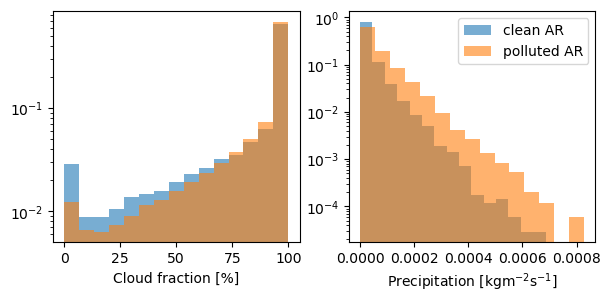

In [21]:
fig, axs = plt.subplots(1,2,dpi=100, figsize=(7,3))

axs[0].hist(clean_clt, alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(clean_clt) + 1. / clean_clt.size)
axs[0].hist(poll_clt,alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(poll_clt) + 1. / poll_clt.size)

axs[1].hist(clean_pr, alpha = 0.6,bins=15, label='clean AR', weights=np.zeros_like(clean_pr) + 1. / clean_pr.size)
axs[1].hist(poll_pr,alpha = 0.6,bins=15, label='polluted AR', weights=np.zeros_like(poll_pr) + 1. / poll_pr.size)

axs[0].set_xlabel('Cloud fraction [%]')
axs[1].set_xlabel('Precipitation [kgm$^{-2}$s$^{-1}$]')

axs[0].set_yscale('log')
axs[1].set_yscale('log')
plt.legend()
plt.show()

In [45]:
aod_hist['ar']=ar_hist.ivt

In [ ]:
hist_vars

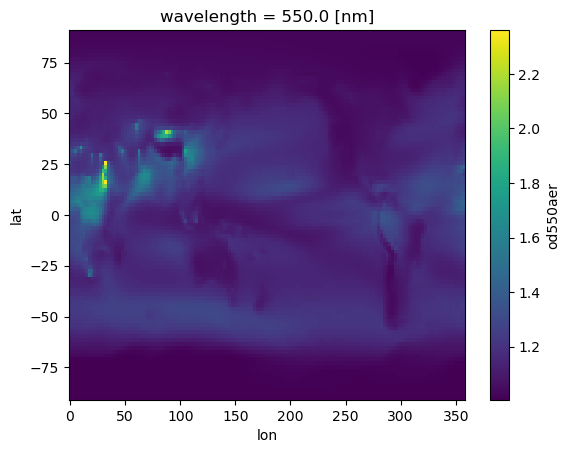

In [72]:
aod_hist.od550aer.mean(dim='time').plot.pcolormesh()

In [74]:
aod_hist.od550aer.min()

<xarray.DataArray 'od550aer' ()>
array(1.00121486)
Coordinates:
    wavelength  float64 550.0